In [54]:
# general imports
import pandas as pd

from imblearn.over_sampling import SMOTE, SMOTENC

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif

from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import NearMiss


from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

from sklearn.model_selection import validation_curve, ShuffleSplit

from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
# mount to google drive to read in data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# read in the train data
train_data = pd.read_csv('/content/drive//MyDrive/University/Year 4/DSA4266/DSA4266 Project 2/Data/fraudTrain.csv')

# read in test data
test_data = pd.read_csv('/content/drive//MyDrive/University/Year 4/DSA4266/DSA4266 Project 2/Data/fraudTest.csv')

In [24]:
combined_data = pd.concat([train_data, test_data])

In [25]:
combined_data.shape

(1852394, 23)

# Data Preparation

### Data Checks

In [26]:
combined_data.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object

In [27]:
# explore column ranges
combined_data.agg(['min','max'])

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
min,0,2019-01-01 00:00:18,60416207185,fraud_Abbott-Rogahn,entertainment,1.0,Aaron,Abbott,F,000 Jennifer Mills,...,20.0271,-165.6723,23,Academic librarian,1924-10-30,00000ecad06b03d3a8d34b4e30b5ce3b,1325376018,19.027422,-166.671575,0
max,1296674,2020-12-31 23:59:34,4992346398065154184,fraud_Zulauf LLC,travel,28948.9,Zachary,Zuniga,M,99736 Rose Shoals Apt. 504,...,66.6933,-67.9503,2906700,Writer,2005-01-29,ffffef9d89e7d02d86efb1d2ba4de008,1388534374,67.510267,-66.950902,1


In [28]:
# explore which columns has nan values
combined_data.isna().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

### Minor Data Edits

In [29]:
# remove unique identifier column
combined_data = combined_data.iloc[: , 1:]


# remove unique trans_num column
combined_data.drop(['trans_num', 'trans_date_trans_time', 'dob'], axis = 1, inplace = True)

### Label Encoding for Categorical Data

In [30]:
# we choose to do label encoding as some of our categorical data has many "categories" (eg. first and last name)
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [31]:
# label encoding
combined_data = MultiColumnLabelEncoder(columns = ['merchant', 'category', 'first', 
                                                   'last', 'gender', 'street', 
                                                   'city', 'state', 'job']).fit_transform(combined_data)

### Splitting of X and Y columns

In [32]:
X = combined_data.copy()
X.drop(['is_fraud'], axis = 1, inplace = True)
y = combined_data[['is_fraud']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.005, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1843132, 18) (1843132, 1)
(9262, 18) (9262, 1)


### Feature Importance

Categorical

In [33]:
# get categorical data
category = ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job']

cat_X_train = X_train[category]
cat_X_test = X_test[category]

In [34]:
# feature selection
def select_features(train_X, train_Y, test_X):
 fs = SelectKBest(score_func=chi2, k='all')
 fs.fit(train_X, train_Y)
 X_train_fs = fs.transform(train_X)
 X_test_fs = fs.transform(test_X)
 return X_train_fs, X_test_fs, fs

merchant: 49.265316
category: 1693.243774
first: 785.300534
last: 16.085470
gender: 34.043084
street: 122.845188
city: 397.272738
state: 1.415372
job: 274.221125


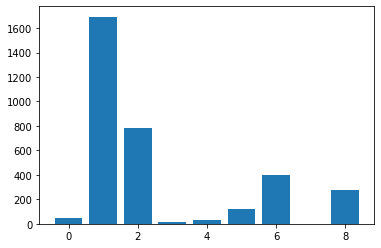

In [35]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(cat_X_train, y_train, cat_X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
 print(category[i] + ': %f' % (fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

Numerical

In [36]:
# get numerical data
category = ['merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job']

num_X_train = X_train.copy()
num_X_train.drop(category, axis = 1, inplace = True)
num_X_test = X_test.copy()
num_X_test.drop(category, axis = 1, inplace = True)

In [37]:
# feature selection
def select_features(X_train, y_train, X_test):
 fs = SelectKBest(score_func=f_classif, k='all')
 fs.fit(X_train, y_train)
 X_train_fs = fs.transform(X_train)
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


cc_num: 2.579186
amt: 84347.726776
zip: 8.419360
lat: 15.048863
long: 1.817052
city_pop: 0.144141
unix_time: 326.752473
merch_lat: 13.871574
merch_long: 1.743455


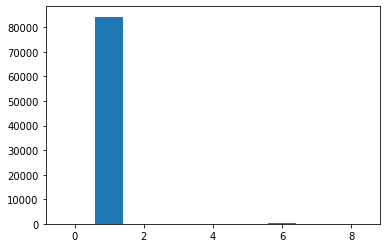

In [38]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(num_X_train, y_train, num_X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
 print(num_X_train.columns[i] + ': %f' % (fs.scores_[i]))
# plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.show()

### NearMiss to balance the data

In [39]:
# check if the data is balanced
print(len(y_train[y_train["is_fraud"] == 1]))
print(len(y_train[y_train["is_fraud"] == 0]))

9601
1833531


In [41]:
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X_train, y_train = undersample.fit_resample(X_train, y_train)

In [42]:
# check data count
print(len(y_train[y_train["is_fraud"] == 1]))
print(len(y_train[y_train["is_fraud"] == 0]))

9601
9601


### Scaling the data

In [43]:
# scale the data using minmax scaler
columns = X_train.columns
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = columns)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = columns)

### Classification Model

In [44]:
# select the important columns for xgboost
selected_col = ["category", "first", "city", "job", "amt", "unix_time"]

X_train = X_train[selected_col]
X_test = X_test[selected_col]

print(X_train.shape)
print(X_test.shape)

(19202, 6)
(9262, 6)


In [45]:
# tune the model
xgb_class = XGBClassifier()
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)

parameters = {"max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              "subsample": [i/10.0 for i in range(1,11)],
              "learning_rate": [0.1, 0.05, 0.01, 0.005, 0.001],
              "gamma" : [0.01, 0.1, 0.5, 1, 2],
              "colsample_bytree": [i/10.0 for i in range(1,11)],
              "reg_alpha":[0, 0.001, 0.005, 0.01, 0.05],
              "min_child_weight": [1, 2, 3, 4, 5],
              "n_estimators": [i for i in range(500, 2001, 100)]}

xgb_rscv = RandomizedSearchCV(xgb_class, param_distributions = parameters, scoring = "roc_auc", cv = skf.split(X_train, y_train.values.ravel()), verbose = 3)
model_xgboost = xgb_rscv.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END colsample_bytree=0.8, gamma=2, learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=1700, reg_alpha=0, subsample=0.7;, score=0.995 total time=  34.9s
[CV 2/5] END colsample_bytree=0.8, gamma=2, learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=1700, reg_alpha=0, subsample=0.7;, score=0.996 total time=  28.1s
[CV 3/5] END colsample_bytree=0.8, gamma=2, learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=1700, reg_alpha=0, subsample=0.7;, score=0.994 total time=  30.7s
[CV 4/5] END colsample_bytree=0.8, gamma=2, learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=1700, reg_alpha=0, subsample=0.7;, score=0.995 total time=  28.2s
[CV 5/5] END colsample_bytree=0.8, gamma=2, learning_rate=0.01, max_depth=10, min_child_weight=1, n_estimators=1700, reg_alpha=0, subsample=0.7;, score=0.996 total time=  28.3s
[CV 1/5] END colsample_bytree=0.1, gamma=0.01, learnin

In [46]:
# model best estimators
print("reg_alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
print("max_depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
print("gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
print("learning_rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
print("min_child_weight: ", model_xgboost.best_estimator_.get_params()["min_child_weight"])
print("subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
print("colsample_bytree: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
print("n_estimators: ", model_xgboost.best_estimator_.get_params()["n_estimators"])

reg_alpha:  0
max_depth:  10
gamma:  2
learning_rate:  0.01
min_child_weight:  1
subsample:  0.7
colsample_bytree:  0.8
n_estimators:  1700


In [47]:
# fill in best estimators to create model
regressor = XGBClassifier(reg_alpha = model_xgboost.best_estimator_.get_params()["reg_alpha"],
                          max_depth = model_xgboost.best_estimator_.get_params()["max_depth"],
                          gamma = model_xgboost.best_estimator_.get_params()["gamma"],
                          learning_rate = model_xgboost.best_estimator_.get_params()["learning_rate"],
                          min_child_weight = model_xgboost.best_estimator_.get_params()["min_child_weight"],
                          subsample = model_xgboost.best_estimator_.get_params()["subsample"],
                          colsample_bytree = model_xgboost.best_estimator_.get_params()["colsample_bytree"], 
                          n_estimators = model_xgboost.best_estimator_.get_params()["n_estimators"]
                          )

In [48]:
# prune the model
max_depth = [1,3,5,7,9,11,13,15]
train_scores, test_scores = validation_curve(regressor, X_train, y_train.values.ravel(), param_name = "max_depth",
                                             param_range = max_depth, cv = 3, scoring = "roc_auc")

In [50]:
# fit the model
regressor.fit(X_train, y_train.values.ravel())

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1700, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Outputs

In [51]:
prediction = regressor.predict(X_test)

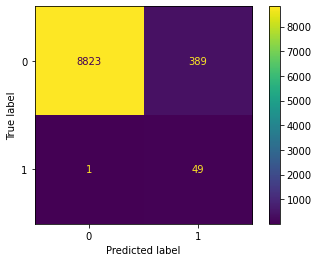

In [52]:
confusion_matrix = metrics.confusion_matrix(y_test["is_fraud"], prediction)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

In [55]:
# Evaluate model
## Calculate the precision
precision = precision_score(y_test["is_fraud"], prediction)
print("Precision: ", precision)

## Calculate the recall
recall = recall_score(y_test["is_fraud"], prediction)
print("Recall: ", recall)

## Calculate the accuracy
accuracy = accuracy_score(y_test["is_fraud"], prediction)
print("Accuracy: ", accuracy)

## Calculate the F1-score
f1 = f1_score(y_test["is_fraud"], prediction)
print("F1-score: ", f1)

Precision:  0.11187214611872145
Recall:  0.98
Accuracy:  0.9578924638307061
F1-score:  0.20081967213114751


### Save model

In [56]:
# save to JSON
regressor.save_model("model1.json")
# save to text format
regressor.save_model("model1.txt")